In [1]:
import pharmada.data.data as data

regkey = '09663'

model = data.Data(regkey)
model

Pharmada model data for Kreisfreie Stadt Würzburg (09663).
Pharmacies in area: 41.
Customers in area:  5272.

In [13]:
import geopandas as gpd
from scipy.spatial import KDTree
import numpy as np
from shapely.geometry import Point, MultiPoint

# Assuming df1 and df2 are your dataframes and they have a 'geometry' column with Point geometries

# Reproject dataframes to a metric CRS (if they aren't in one already) for correct distance calculation
crs = model.AreaGeometry.geometry.estimate_utm_crs()
customers = model.Customers.customers.to_crs(crs)
pharmacies = model.Pharmacies.pharmacies.to_crs(crs)

def closest(point, points):
    """Return closest point from a list of points."""
    return points[np.argmin([point.distance(p) for p in points])]

# Create KDTree object
tree = KDTree(pharmacies.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

# Find indices of the nearest pharmacy for each customer
distances, indices = tree.query(customers.geometry.apply(lambda geom: (geom.x, geom.y)).tolist(), k=1)

# Add nearest pharmacy id to customer df
customers['nearest_pharmacy'] = indices.tolist()


In [14]:
results = []

# Assign customers to pharmacies and write results to GeoDataFrame
for pharmacy_id in pharmacies.index:
    customers_at_pharmacy = customers.loc[customers["nearest_pharmacy"] == pharmacy_id, "geometry"]
    if not customers_at_pharmacy.empty:
        results.append({"pharmacy_id": pharmacy_id, "customers": MultiPoint(customers_at_pharmacy.tolist())})

results = gpd.GeoDataFrame(results, geometry="customers")

# Convert 'pharmacy_id' to int and 'customers' to GeoSeries
results["pharmacy_id"] = results["pharmacy_id"].astype(int)
results["customers"] = gpd.GeoSeries(results["customers"])

# Set the CRS for the GeoDataFrame to match the input DataFrames
results.set_crs(crs, inplace=True)  # adjust this to match your CRS

,pharmacy_id,customers
0,0,"MULTIPOINT (569416.645 5507579.220, 569334.465..."
1,1,"MULTIPOINT (568740.179 5510478.228, 568849.122..."
2,2,"MULTIPOINT (568256.611 5511931.027, 568093.352..."
3,3,"MULTIPOINT (567053.677 5512138.106, 567063.198..."
4,4,"MULTIPOINT (564523.874 5513335.541, 564554.448..."
5,5,"MULTIPOINT (564621.729 5517131.902, 564114.655..."
6,6,"MULTIPOINT (567246.242 5514930.055, 567309.938..."
7,7,"MULTIPOINT (565624.862 5513608.721, 565783.222..."
8,8,"MULTIPOINT (565783.571 5515154.395, 565804.037..."
9,9,"MULTIPOINT (566237.368 5515167.346, 566309.603..."


In [15]:
num_cus = results.apply(lambda x: len(x['customers'].geoms), axis=1)
pharmacies['num_cus'] = num_cus

<Axes: >

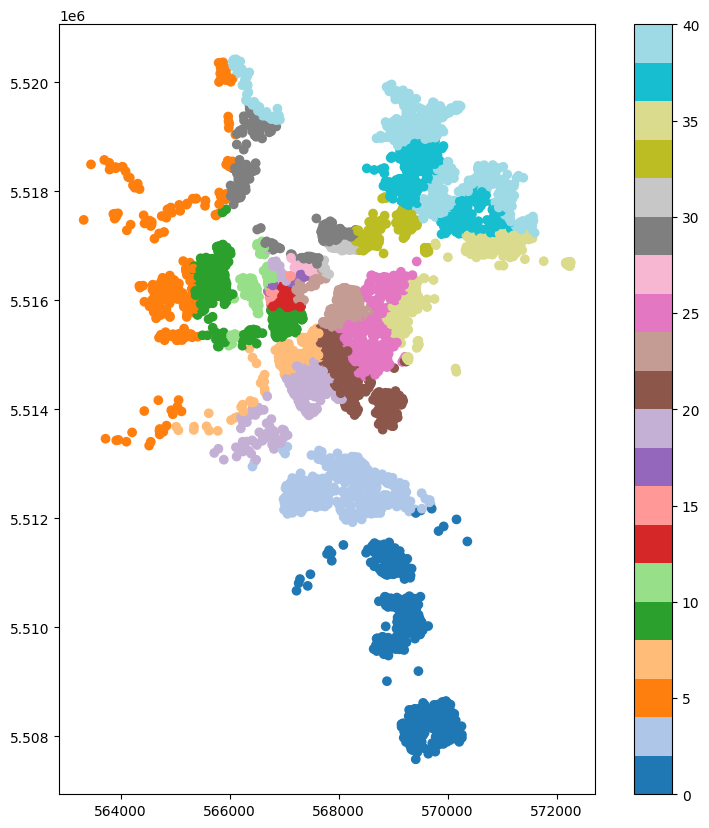

In [16]:
customers.groupby('nearest_pharmacy')
customers.plot(cmap='tab20', column='nearest_pharmacy', legend=True, figsize=(10, 10))

In [17]:
test = customers.groupby('nearest_pharmacy').aggregate({'geometry': lambda x: MultiPoint(x.tolist())})

<Axes: >

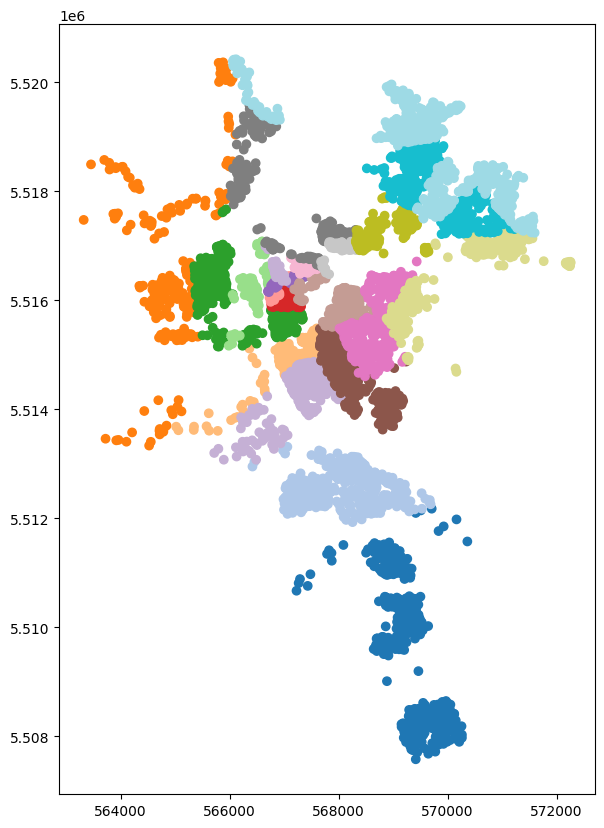

In [18]:
test.set_geometry('geometry', inplace=True)
test.plot(cmap='tab20', figsize=(10, 10))

In [19]:
customers

,geometry,regkey,name,nearest_pharmacy
0,POINT (569416.645 5507579.220),09663,Kreisfreie Stadt Würzburg,0
1,POINT (569334.465 5507762.614),09663,Kreisfreie Stadt Würzburg,0
2,POINT (569360.682 5507746.809),09663,Kreisfreie Stadt Würzburg,0
3,POINT (569444.274 5507706.191),09663,Kreisfreie Stadt Würzburg,0
4,POINT (569646.945 5507681.092),09663,Kreisfreie Stadt Würzburg,0
...,...,...,...,...
5275,POINT (566332.247 5519945.080),09663,Kreisfreie Stadt Würzburg,38
5276,POINT (565893.802 5520064.122),09663,Kreisfreie Stadt Würzburg,5
5277,POINT (566034.509 5520064.099),09663,Kreisfreie Stadt Würzburg,5
5278,POINT (566099.489 5520299.343),09663,Kreisfreie Stadt Würzburg,38


In [ ]:
http://download.geofabrik.de/europe/germany/bayern/unterfranken-latest.osm.pbf